# CNN_Data_Augumentation
pytorchでのデータ拡張: データをロードする度にランダムにtransformの処理が実行される

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
val_transform = transforms.Compose([
    transforms.ToTensor(), # Tensorかつチャネルファーストに変換
    transforms.Normalize((0.5), (0.5)) # N(0.5, 0.5)に正規化
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),# ランダムに左右を入れ替える
    transforms.ColorJitter(), # 明度・彩度・色相・コントラストを変える
    transforms.RandomRotation(10), # 角度を変える
    transforms.ToTensor(), # Tensorかつチャネルファーストに変換
    transforms.Normalize((0.5), (0.5)) # N(0.5, 0.5)に正規化
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [7]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )
    self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [8]:
model = CNN(10) # クラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) #weight_decay: L2正則化

In [10]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  for imgs, labels in train_dataloader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output, labels)
    loss.backward()
    running_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    running_acc += torch.mean(pred.eq(labels).float())
    optimizer.step()
  running_loss /= len(train_dataloader)
  running_acc /= len(train_dataloader)
  losses.append(running_loss)
  accs.append(running_acc)
  #
  # validation loop
  #
  val_running_loss = 0.0
  val_running_acc = 0.0
  for val_imgs, val_labels in validation_dataloader:
    val_imgs = val_imgs.to(device)
    val_labels = val_labels.to(device)
    val_output = model(val_imgs)
    val_loss = criterion(val_output, val_labels)
    val_running_loss += val_loss.item()
    val_pred = torch.argmax(val_output, dim=1)
    val_running_acc += torch.mean(val_pred.eq(val_labels).float())
  val_running_loss /= len(validation_dataloader)
  val_running_acc /= len(validation_dataloader)
  val_losses.append(val_running_loss)
  val_accs.append(val_running_acc)
  print("epoch: {}, loss: {}, acc: {}, \
  val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.4661125277984774, acc: 0.46661069989204407,   val loss: 1.1377329959656104, val acc: 0.5886581540107727
epoch: 1, loss: 1.0484582527814121, acc: 0.6300383806228638,   val loss: 0.9430811622272284, val acc: 0.6696285605430603
epoch: 2, loss: 0.8912823302427012, acc: 0.6878598928451538,   val loss: 0.8608478447690178, val acc: 0.6992811560630798
epoch: 3, loss: 0.7968882586776028, acc: 0.7213691473007202,   val loss: 0.7423331920331279, val acc: 0.7405151724815369
epoch: 4, loss: 0.7344757426036754, acc: 0.7436220645904541,   val loss: 0.7203855341234908, val acc: 0.7504991888999939
epoch: 5, loss: 0.7001092062306115, acc: 0.7556381821632385,   val loss: 0.7000822459166043, val acc: 0.7610822319984436
epoch: 6, loss: 0.6606990067396725, acc: 0.7693737745285034,   val loss: 0.6528161112873699, val acc: 0.7691693305969238
epoch: 7, loss: 0.6359634495513682, acc: 0.7787308096885681,   val loss: 0.6461787296179384, val acc: 0.7761581540107727
epoch: 8, loss: 0.6220004356734

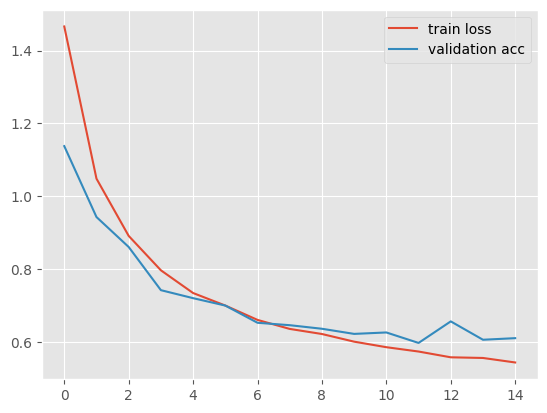

In [11]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation acc")
plt.legend()

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

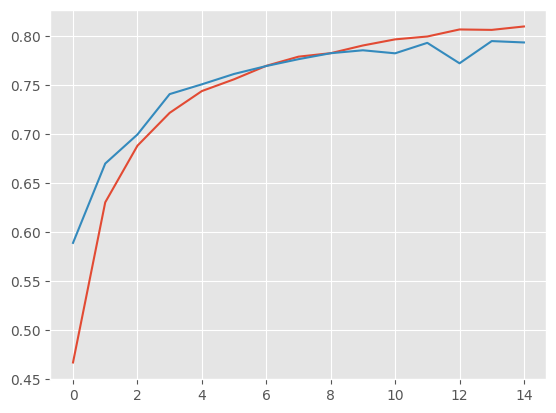

In [12]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend